# 短指令辨識

## 載入相關套件

In [1]:
# 載入相關套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import pathlib
import csv
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# 不顯示警告訊息
import warnings
warnings.filterwarnings('ignore')

## 載入檔案

(19757,)


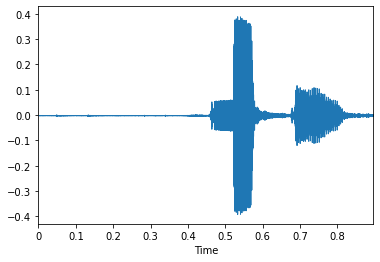

In [5]:
# 任選一檔案測試，發音為 happy
train_audio_path = './GoogleSpeechCommandsDataset/data/'
data, sr = librosa.load(train_audio_path+'happy/0ab3b47d_nohash_0.wav')

# 繪製波形
librosa.display.waveplot(data, sr)
print(data.shape)

In [4]:
# 播放
from IPython.display import Audio

Audio(data, rate=sr)

In [6]:
# 取得音檔的屬性
import wave

wav_file = train_audio_path+'happy/0ab3b47d_nohash_0.wav'
f=wave.open(wav_file)
print(f'取樣頻率={f.getframerate()}, 幀數={f.getnframes()}, ' +
      f'聲道={f.getnchannels()}, 精度={f.getsampwidth()}, ' +
      f'檔案秒數={f.getnframes() / f.getframerate():.2f}')
f.close()

nchannels2 = f.getnchannels()
sample_rate2 = f.getframerate()
sample_width2 = f.getsampwidth()


取樣頻率=16000, 幀數=14336, 聲道=1, 精度=2, 檔案秒數=0.90


In [6]:
# 取三個目錄測試
labels=os.listdir(train_audio_path)
labels

['bed', 'cat', 'happy']

檔案數=1713


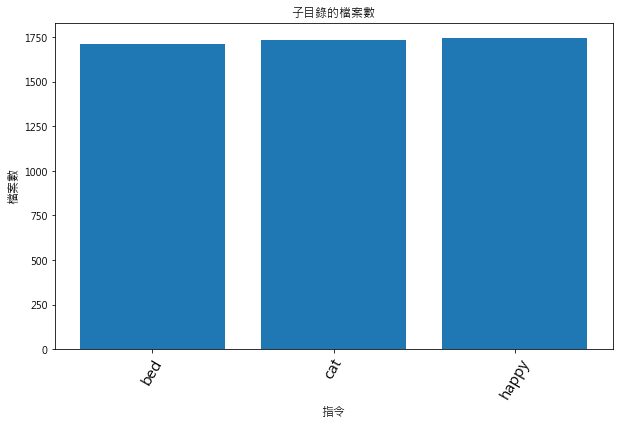

In [7]:
# 子目錄的檔案數
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
# 繪圖
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,6))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('指令', fontsize=12)
plt.ylabel('檔案數', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('子目錄的檔案數')
print(f'檔案數={no_of_recordings[0]}')
plt.show()

(1484, 8000)
(1515, 8000)
(1549, 8000)


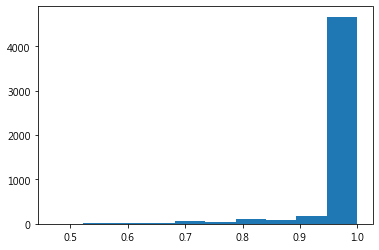

In [14]:
# 載入音樂檔案
duration_of_recordings=[]
all_wave = []
y = []
for i, label in enumerate(labels):
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    class_wave=None
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
        # 重抽樣，統一取 8000 個樣本
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            if class_wave is None:
                class_wave = np.array(samples).reshape(1, -1) 
            else:
                class_wave = np.concatenate([class_wave, np.array(samples).reshape(1, -1)], axis=0)
            y.append(i)
    all_wave.append(class_wave)
    # 存成 npy
    print(class_wave.shape)
    np.save('./GoogleSpeechCommandsDataset/' + label + '.npy', class_wave)
            
fig = plt.hist(np.array(duration_of_recordings))

In [10]:
y[:10], y[-10:]

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [12]:
len(all_wave)

3

In [3]:
# load data
train_audio_path2 = './GoogleSpeechCommandsDataset/'
npy_files = [f for f in os.listdir(train_audio_path2) if f.endswith('.npy')]
# npy_files
all_wave = []
y = []
no=0
for i, label in enumerate(npy_files):
    class_wave = np.load(train_audio_path2+label)
    all_wave.append(class_wave)
    print(class_wave.shape)
    no+=class_wave.shape[0]
    y.extend(np.full(class_wave.shape[0], i))
    

(1484, 8000)
(1515, 8000)
(1549, 8000)


In [9]:
# 標準化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
for i in range(len(all_wave)):
    all_wave[i] = scaler.fit_transform(all_wave[i])

In [10]:
# 計算 MFCC
X = None
for class_wave in all_wave:
    for data in class_wave:
        mfcc = librosa.feature.mfcc(y=data, sr=8000, n_mfcc=40)
        # print(data.shape, mfcc.shape)
        if X is None:
            X = mfcc.reshape(1, 40, -1, 1)
        else:
            X = np.concatenate((X, mfcc.reshape(1, 40, -1, 1)), axis=0)

print(X.shape, len(y))

(4548, 40, 16, 1) 4548


In [12]:
# 資料切割
from sklearn.model_selection import train_test_split
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train.shape, X_test.shape

((3638, 40, 16, 1), (910, 40, 16, 1))

In [13]:
# CNN 模型
input_shape = X_train.shape[1:]
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(3, activation="softmax"),
    ]
)

In [14]:
# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 模型訓練
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2)

# 評分(Score Model)
score=model.evaluate(X_test, y_test, verbose=0)

for i, x in enumerate(score):
    print(f'{model.metrics_names[i]}: {score[i]:.4f}')

Epoch 1/20
91/91 [==============================] - 5s 9ms/step - loss: 2.3254 - accuracy: 0.5843 - val_loss: 0.2243 - val_accuracy: 0.9313
Epoch 2/20
91/91 [==============================] - 1s 6ms/step - loss: 0.3088 - accuracy: 0.8875 - val_loss: 0.1479 - val_accuracy: 0.9547
Epoch 3/20
91/91 [==============================] - 1s 6ms/step - loss: 0.2120 - accuracy: 0.9244 - val_loss: 0.1249 - val_accuracy: 0.9574
Epoch 4/20
91/91 [==============================] - 1s 6ms/step - loss: 0.1536 - accuracy: 0.9439 - val_loss: 0.1008 - val_accuracy: 0.9684
Epoch 5/20
91/91 [==============================] - 1s 6ms/step - loss: 0.1316 - accuracy: 0.9583 - val_loss: 0.0987 - val_accuracy: 0.9602
Epoch 6/20
91/91 [==============================] - 1s 6ms/step - loss: 0.1173 - accuracy: 0.9593 - val_loss: 0.0801 - val_accuracy: 0.9725
Epoch 7/20
91/91 [==============================] - 1s 6ms/step - loss: 0.1165 - accuracy: 0.9620 - val_loss: 0.0851 - val_accuracy: 0.9657
Epoch 8/20
91/91 [==

## 準確率繪圖

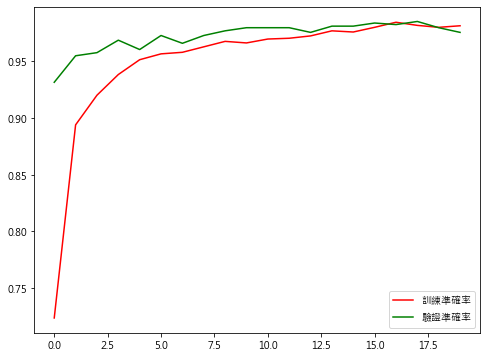

In [15]:
# 對訓練過程的準確率繪圖
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], 'r', label='訓練準確率')
plt.plot(history.history['val_accuracy'], 'g', label='驗證準確率')
plt.legend()

In [60]:
# 麥克風收音 1
import pyaudio
import sys
from array import array
from sys import byteorder
import wave

file_path = './GoogleSpeechCommandsDataset/happy.wav'
CHUNK = 1024
FORMAT = sample_width2 # pyaudio.paInt16
CHANNELS = nchannels2
SAMPLE_RATE = sample_rate2 

# 錄音長度
RECORD_SECONDS = 1
p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS, 
                rate=SAMPLE_RATE, 
                input=True,
                output=True,
                frames_per_buffer=CHUNK)
wf = wave.open(file_path, 'wb')
wf.setnchannels(CHANNELS)
# sample_width: 2 ==> 16 bits, 1 ==> 8 bits
sample_width = p.get_sample_size(FORMAT)
wf.setsampwidth(sample_width)
wf.setframerate(SAMPLE_RATE)
print ("start recording")

# https://docs.python.org/zh-tw/3/library/array.html
# signed short
data_all=[]
no_of_frames = int(SAMPLE_RATE / CHUNK * RECORD_SECONDS)
for i in range(no_of_frames):
    data = stream.read(CHUNK)
    #print(type(data))
    #print(len(data))
    wf.writeframes(data)
    data_all += data
print ("end recording")

print(f'no_of_frames={no_of_frames}')
print(f'no_of_seconds={no_of_frames*CHUNK/RATE}')
print(f'data length={len(data_all)}')
print ("end recording")

start recording
end recording
no_of_frames=15
no_of_seconds=0.96
data length=61440
end recording


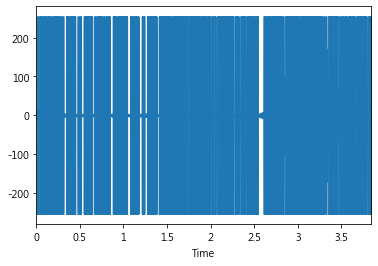

In [61]:
# 繪製波形
samples = np.array(data_all)
samples = samples.astype(np.float)
librosa.display.waveplot(np.array(samples), SAMPLE_RATE)

In [51]:
# 重抽樣，統一取 8000 個樣本
samples2 = librosa.resample(samples, SAMPLE_RATE, 8000)
mfcc = librosa.feature.mfcc(y=samples2, sr=SAMPLE_RATE, n_mfcc=40)
mfcc = mfcc[:, :input_shape[1]]
samples2.shape, mfcc.shape

((30720,), (40, 16))

In [52]:
X_pred = mfcc.reshape(1, *mfcc.shape, 1)
# 常態化
X_norm = (X_pred - X_pred.min(axis=0)) / (X_pred.max(axis=0) - X_pred.min(axis=0))
print(X_norm.shape)
model.predict(X_norm)

(1, 40, 16, 1)


array([[0.37578008, 0.3646183 , 0.25960162]], dtype=float32)

(21168,)


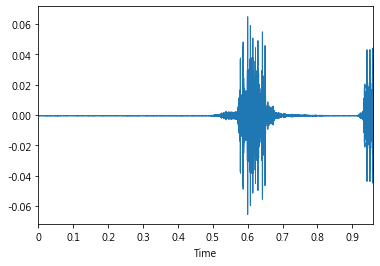

In [69]:
# 測試，發音為 happy
train_audio_path = './GoogleSpeechCommandsDataset/'
data, sr = librosa.load('./GoogleSpeechCommandsDataset/happy2.wav')

# 繪製波形
librosa.display.waveplot(data, sr)
print(data.shape)

In [67]:
samples = librosa.resample(data, sample_rate, 8000)
mfcc = librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=40)
mfcc.shape

(40, 16)

In [68]:
X_pred = mfcc.reshape(1, *mfcc.shape, 1)
# 常態化
X_norm = (X_pred - X_pred.min(axis=0)) / (X_pred.max(axis=0) - X_pred.min(axis=0))
model.predict(X_norm)

array([[0.37578008, 0.3646183 , 0.25960162]], dtype=float32)

(21168,)


array([[0.37578008, 0.3646183 , 0.25960162]], dtype=float32)

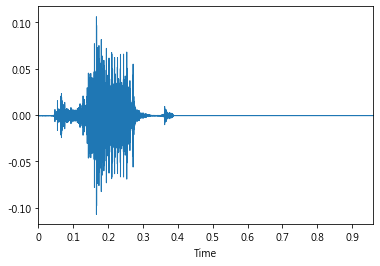

In [65]:
# 測試，發音為 cat
train_audio_path = './GoogleSpeechCommandsDataset/'
data, sr = librosa.load('./GoogleSpeechCommandsDataset/cat.wav')

# 繪製波形
librosa.display.waveplot(data, sr)
print(data.shape)

samples = librosa.resample(data, sample_rate, 8000)
mfcc = librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=40)
X_pred = mfcc.reshape(1, *mfcc.shape, 1)
# 常態化
X_norm = (X_pred - X_pred.min(axis=0)) / (X_pred.max(axis=0) - X_pred.min(axis=0))
model.predict(X_norm)

(21168,)


array([[0.35585204, 0.40219218, 0.2419558 ]], dtype=float32)

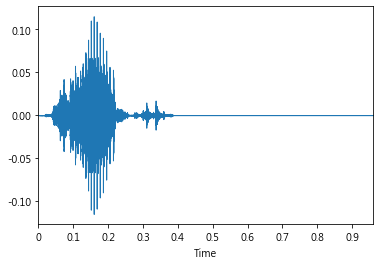

In [49]:
# 測試，發音為 bed
train_audio_path = './GoogleSpeechCommandsDataset/'
data, sr = librosa.load('./GoogleSpeechCommandsDataset/bed.wav')

# 繪製波形
librosa.display.waveplot(data, sr)
print(data.shape)

samples = librosa.resample(data, sample_rate, 8000)
mfcc = librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=40)
X_pred = mfcc.reshape(1, *mfcc.shape, 1)
X_norm = (X_pred - X_pred.min(axis=0)) / (X_pred.max(axis=0) - X_pred.min(axis=0))
model.predict(X_norm)

(22050,)


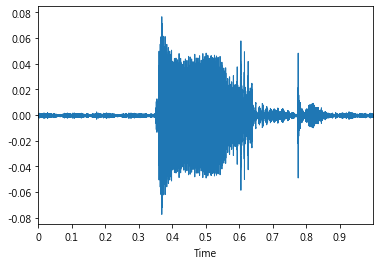

In [43]:
# 任選一檔案測試，發音為 bed
train_audio_path = './GoogleSpeechCommandsDataset/data/'
data, sr = librosa.load(train_audio_path+'bed/00f0204f_nohash_0.wav')

# 繪製波形
librosa.display.waveplot(data, sr)
print(data.shape)

In [1]:
# 麥克風收音 2
import pyaudio
import sys
from array import array
from sys import byteorder
import wave

CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000 
# 錄音長度 = RECORD_SECONDS - 1
RECORD_SECONDS = 3
THRESHOLD = 200

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS, 
                rate=RATE, 
                input=True,
                output=True,
                frames_per_buffer=CHUNK)
print ("start recording")

# https://docs.python.org/zh-tw/3/library/array.html
# signed short
r = array('h')
no_of_frames=0
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    # check for silence here by comparing the level with 0 (or some threshold) for 
    # the contents of data.
    # then write data or not to a file
    snd_data = array('h', data)
    if byteorder == 'big':
        snd_data.byteswap()
    r.extend(snd_data)
    if max(snd_data) > THRESHOLD:
        no_of_frames+=1
    
# append silient to 1 second
all_data = array('h')
total_frames = int(RATE / CHUNK)
for j in range(no_of_frames, total_frames):
    for i in range(CHUNK):
        r.extend(b'\x00')

stream.stop_stream()
stream.close()
p.terminate()

print(f'no_of_frames={no_of_frames}')
print(f'no_of_seconds={no_of_frames*CHUNK/RATE}')
print ("end recording")

samples = np.array(r)

start recording
no_of_frames=3
no_of_seconds=0.384
end recording
